<a href="https://colab.research.google.com/github/arunraja-hub/Preference_Extraction/blob/hidden_RWNN_mnist_test/mnist_with_modified_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
%tensorflow_version 2.x

!git clone https://github.com/arunraja-hub/Preference_Extraction.git

Cloning into 'Preference_Extraction'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 696 (delta 53), reused 31 (delta 25), pack-reused 608
Receiving objects: 100% (696/696), 21.62 MiB | 14.02 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [0]:
from __future__ import print_function
import argparse
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.autograd as autograd
from torchsummary import summary

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import concurrent.futures
import itertools
import os
import random
import sys
import time
import re
import io

import sys

sys.path.append('Preference_Extraction')
from imports_data import all_load_data

In [0]:
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Subnets Methods

In [0]:
"""
    Original code from What's hidden in a randomly weighted neural network? paper
    Implemented at https://github.com/allenai/hidden-networks
    Remove weigths-initialisation since it is not relevant for us
"""

class GetSubnet(autograd.Function):
    @staticmethod
    def forward(ctx, scores, k):
        # Get the supermask by sorting the scores and using the top k%
        out = scores.clone()
        _, idx = scores.flatten().sort()
        j = int((1 - k) * scores.numel())

        # flat_out and out access the same memory.
        flat_out = out.flatten()
        flat_out[idx[:j]] = 0
        flat_out[idx[j:]] = 1

        return out

    @staticmethod
    def backward(ctx, g):
        # send the gradient g straight-through on the backward pass.
        return g, None

class SupermaskConv(nn.Conv2d):
    def __init__(self, *args, k, **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k

        # initialize the scores
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        # initialize the weights
        nn.init.uniform_(self.weight)
        
        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False

    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), self.k)
        w = self.weight * subnet
        x = F.conv2d(
            x, w, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        return x

class SupermaskLinear(nn.Linear):
    def __init__(self, *args, k, **kwargs):
        super().__init__(*args, **kwargs)
        self.k = k

        # initialize the scores
        self.scores = nn.Parameter(torch.Tensor(self.weight.size()))
        nn.init.kaiming_uniform_(self.scores, a=math.sqrt(5))

        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5)) # Mnist test edit

        # NOTE: turn the gradient on the weights off
        self.weight.requires_grad = False

    def forward(self, x):
        subnet = GetSubnet.apply(self.scores.abs(), self.k)
        w = self.weight * subnet
        return F.linear(x, w, self.bias)
        return x

# NOTE: not used here but we use NON-AFFINE Normalization!
# So there is no learned parameters for your nomralization layer.
class NonAffineBatchNorm(nn.BatchNorm2d):
    def __init__(self, dim):
        super(NonAffineBatchNorm, self).__init__(dim, affine=False)

## Define Supermask Network

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [0]:
"""
    Class modified from above to become enseble of Qhead subnetwrosk
"""

class SuperMaskQNets(nn.Module):
    def __init__(self, k, q_head_index, q_means_stds):
        super(SuperMaskQNets, self).__init__()
        self.conv1 = SupermaskConv(in_channels=1, out_channels=16, kernel_size=3, stride=1, bias=True, k=k) # Mnist test edit
        self.conv2 = SupermaskConv(in_channels=16, out_channels=32, kernel_size=3, stride=2, bias=True, k=k)
        self.fc1 = SupermaskLinear(in_features=4608, out_features=64, bias=True, k=k) # Mnist test edit
        self.fc2 = SupermaskLinear(in_features=64, out_features=3, bias=True, k=k)

        assert q_head_index < 3, 'Model has only 3 qHeads'
        self.qix = q_head_index
        self.qu_mu_s = q_means_stds

    def fwd_conv1(self, x):
        x = self.conv1(x)
        return F.relu(x)

    def fwd_conv2(self, x):
        x = self.fwd_conv1(x)
        x = self.conv2(x)
        return F.relu(x)

    def fwd_flat(self, x):
        x = self.fwd_conv2(x)
        return torch.flatten(torch.transpose(x, 1, 3), 1) # Pre-flattening transpose is necessary for TF-Torch conversion

    def fwd_fc1(self, x):
        x = self.fwd_flat(x)
        x = self.fc1(x)
        return F.relu(x)
    
    def fwd_fc2(self, x):
        x = self.fwd_fc1(x)
        return self.fc2(x)

    def forward(self, x):
        x = self.fwd_fc2(x)[: ,self.qix]
        x -= self.qu_mu_s[self.qix][0]
        x /= self.qu_mu_s[self.qix][1]
        return torch.sigmoid(x)

## Mnist Test

Compare results with https://github.com/arunraja-hub/Preference_Extraction/blob/hidden_RWNN_mnist_test/mnist_original.ipynb

In [0]:
# Let's test that model can recognise 0s from the rest

from torchvision import datasets, transforms

data_path = './data'

if not os.path.exists(data_path):
  os.mkdir(data_path)

batch_size = 64
test_batch_size = 64

mnist_train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join(data_path, 'mnist'), train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(os.path.join(data_path, 'mnist'), train=False, download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=test_batch_size, shuffle=True)

tensor([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


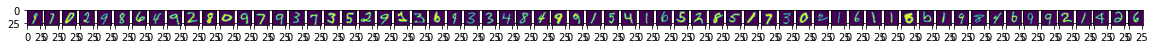

In [51]:
class Denormalize(object):
    def __init__(self, mean, std, inplace=False):
        self.mean = mean
        self.demean = [-mean / std]
        self.std = std
        self.destd = [1 / std]
        self.inplace = inplace

    def __call__(self, tensor):
        tensor = TF.normalize(tensor, self.demean, self.destd, self.inplace)
        # clamp to get rid of numerical errors
        return torch.clamp(tensor, 0.0, 1.0)


def show_batch(dataloader):
    fig, ax = plt.subplots(1, dataloader.batch_size, sharex=True, sharey=True, figsize=(20, 10))
    img_batch, label = iter(dataloader).next()
    label = (label > 0).float()
    denormalize = Denormalize((0.1307), (0.3081))  
    
    print(label)
    for i in range(dataloader.batch_size):                                
        ax[i].imshow(transforms.ToPILImage()(denormalize(img_batch[i, :, :, :])))

show_batch(mnist_train_loader)

In [0]:
"""
    Train/Test function for Randomly Weighted Hidden Neural Networks Techniques
    Adapted from https://github.com/NesterukSergey/hidden-networks/blob/master/demos/mnist.ipynb
"""

def train(model, device, train_loader, optimizer, criterion, verbose=False):
    
    train_loss = 0
    true_labels = []
    predictions = [] # labels
    outputs = [] # probabilities

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        target = (target > 0).float()
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss
        output_value = output.detach().cpu().numpy()
        outputs.append(output)
        pred = (output_value > 0.5).astype(float)
        predictions.extend(pred)
        true_labels.extend(target.detach().cpu().numpy())

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    outputs = np.array(outputs)
    train_loss /= len(train_loader.dataset)
    accuracy = np.sum(np.equal(predictions, true_labels)) / len(true_labels)
    auc = roc_auc_score(true_labels, predictions)

    return train_loss.item(), accuracy, auc


def test(model, device, criterion, test_loader):
    true_labels = []
    predictions = [] # labels
    outputs = [] # probabilities

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            target = (target > 0).float()
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target)

            output_value = output.detach().cpu().numpy()
            outputs.append(output)
            pred = (output_value > 0.5).astype(float)
            predictions.extend(pred)
            true_labels.extend(target.detach().cpu().numpy())

    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    outputs = np.array(outputs)
    test_loss /= len(test_loader.dataset)
    accuracy = np.sum(np.equal(predictions, true_labels)) / len(true_labels)
    auc = roc_auc_score(true_labels, predictions)

    return test_loss.item(), accuracy, auc

def run_model(model, num_epochs, verbose=False):
  # NOTE: only pass the parameters where p.requires_grad == True to the optimizer! Important!
  optimizer = optim.SGD(
      [p for p in model.parameters() if p.requires_grad],
      lr=0.1,
      momentum=0.9,
      weight_decay=0.0005,
  )

  criterion = nn.BCELoss().to(device)
  scheduler = CosineAnnealingLR(optimizer, T_max=14)

  train_accs = []
  train_aucs = []
  test_accs = []
  test_aucs = []

  for epoch in tqdm(range(num_epochs)):
      train_loss, train_accuracy, train_auc = train(model, device, mnist_train_loader, optimizer, criterion, verbose=False)
      test_loss, test_accuracy, test_auc = test(model, device, criterion, mnist_test_loader)
      if verbose:
        print(f'Epoch {epoch}: train loss - {train_loss} / test loss {test_loss}')
      scheduler.step()

      train_accs.append(train_accuracy)
      train_aucs.append(train_auc)
      test_accs.append(test_accuracy)
      test_aucs.append(test_auc)

  print('Train accuracy: ', train_accs[-1])
  print('Test accuracy: ', test_accs[-1])

  print('Train AUC: ', train_aucs[-1])  
  print('Test AUC: ', test_aucs[-1])

In [36]:
mnist_test_model = SuperMaskQNets(k=0.3, q_head_index=0, q_means_stds={0: (0, 1)})
mnist_test_model.to(device)

SuperMaskQNets(
  (conv1): SupermaskConv(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): SupermaskConv(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (fc1): SupermaskLinear(in_features=4608, out_features=64, bias=True)
  (fc2): SupermaskLinear(in_features=64, out_features=3, bias=True)
)

In [46]:
run_model(mnist_test_model, num_epochs=10, verbose=True)




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:14<02:13, 14.82s/it]

Epoch 0: train loss - 0.1543489545583725 / test loss 0.1535937488079071





 20%|██        | 2/10 [00:29<01:58, 14.81s/it]

Epoch 1: train loss - 0.15427082777023315 / test loss 0.1535937488079071





 30%|███       | 3/10 [00:44<01:43, 14.83s/it]

Epoch 2: train loss - 0.15432292222976685 / test loss 0.1535937488079071





 40%|████      | 4/10 [00:59<01:28, 14.83s/it]

Epoch 3: train loss - 0.1544010490179062 / test loss 0.1535937488079071





 50%|█████     | 5/10 [01:14<01:14, 14.82s/it]

Epoch 4: train loss - 0.15432292222976685 / test loss 0.15453124046325684





 60%|██████    | 6/10 [01:28<00:59, 14.83s/it]

Epoch 5: train loss - 0.154296875 / test loss 0.1535937488079071





 70%|███████   | 7/10 [01:43<00:44, 14.86s/it]

Epoch 6: train loss - 0.15432292222976685 / test loss 0.15406249463558197





 80%|████████  | 8/10 [01:58<00:29, 14.85s/it]

Epoch 7: train loss - 0.154296875 / test loss 0.15312500298023224





 90%|█████████ | 9/10 [02:13<00:14, 14.85s/it]

Epoch 8: train loss - 0.15437500178813934 / test loss 0.15406249463558197





100%|██████████| 10/10 [02:28<00:00, 14.83s/it]

Epoch 9: train loss - 0.15427082777023315 / test loss 0.15312500298023224
Train accuracy:  0.9012833333333333
Test accuracy:  0.902
Train AUC:  0.5
Test AUC:  0.5


## Mnist Test with QNet Weights

In [56]:
new_save_path = "Preference_Extraction/saved_model2"
restored_model = tf.keras.models.load_model(new_save_path)
restored_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork/conv2d (Conv (None, 12, 14, 16)        736       
_________________________________________________________________
EncodingNetwork/conv2d_1 (Co (None, 5, 6, 32)          4640      
_________________________________________________________________
flatten (Flatten)            (None, 960)               0         
_________________________________________________________________
EncodingNetwork/dense (Dense (None, 64)                61504     
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 67,075
Trainable params: 67,075
Non-trainable params: 0
_________________________________________________________________


In [0]:
original_weights=restored_model.get_weights()

In [0]:
new_flt_weights = np.random.rand(64, 4608)
new_flt_weights[:, :original_weights[4].shape[0]] = np.transpose(original_weights[4])
new_flt_weights = new_flt_weights.astype(np.float32)

In [0]:
def load_weights(model):
  model.conv1.weight.data = torch.from_numpy(np.transpose(original_weights[0][:,:,:1,:])) # Mnist test edit
  model.conv1.bias.data = torch.from_numpy(original_weights[1])
  model.conv2.weight.data = torch.from_numpy(np.transpose(original_weights[2]))
  model.conv2.bias.data = torch.from_numpy(original_weights[3])
  model.fc1.weight.data = torch.from_numpy(new_flt_weights) # Mnist test edit
  model.fc1.bias.data = torch.from_numpy(original_weights[5])
  model.fc2.weight.data = torch.from_numpy(np.transpose(original_weights[6]))
  model.fc2.bias.data = torch.from_numpy(original_weights[7])
  model.to(device)

In [0]:
supermask_test_model = SuperMaskQNets(k=1, q_head_index=0, q_means_stds=[0, 1]).to(device)
load_weights(supermask_test_model)

In [106]:
def get_q_heads_mu_and_sigma(model, all_obs, num_obs):
    
    model.eval()

    all_obs = shuffle(all_obs)
    obs_to_pass = all_obs[:num_obs]

    obs_tensor = torch.Tensor(obs_to_pass)
    obs_tensor = obs_tensor.to(device)
    qheads_values = model.fwd_fc2(obs_tensor).detach().cpu().numpy()

    mu = qheads_values.mean(axis=0)
    s = qheads_values.std(axis=0)

    qheads_mu_s = {}
    for qix in range(len(mu)):
        qheads_mu_s[qix] = (mu[qix], s[qix])
    
    return qheads_mu_s

img_batch, label = iter(train_loader).next()
q_mu_s = get_q_heads_mu_and_sigma(supermask_test_model, img_batch, 10000)
q_mu_s

{0: (22205.838, 2209.995),
 1: (27808.318, 2865.4934),
 2: (39502.633, 3517.6897)}

In [0]:
K = 0.5

spmsk_model_q0 = SuperMaskQNets(k=K, q_head_index=0, q_means_stds=q_mu_s).to(device)
load_weights(spmsk_model_q0)

spmsk_model_q1 = SuperMaskQNets(k=K, q_head_index=1, q_means_stds=q_mu_s).to(device)
load_weights(spmsk_model_q1)

spmsk_model_q2 = SuperMaskQNets(k=K, q_head_index=2, q_means_stds=q_mu_s).to(device)
load_weights(spmsk_model_q1)

In [108]:
run_model(spmsk_model_q0, num_epochs=10, verbose=True)




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:15<02:15, 15.10s/it]

Epoch 0: train loss - 0.0008909045136533678 / test loss 0.0002996288822032511





 20%|██        | 2/10 [00:30<02:00, 15.09s/it]

Epoch 1: train loss - 0.0003657228371594101 / test loss 0.0003216312325093895





 30%|███       | 3/10 [00:45<01:45, 15.09s/it]

Epoch 2: train loss - 0.0003955821448471397 / test loss 0.00032753669074736536





 40%|████      | 4/10 [01:00<01:30, 15.08s/it]

Epoch 3: train loss - 0.00039304079837165773 / test loss 0.00045023541315458715





 50%|█████     | 5/10 [01:15<01:15, 15.09s/it]

Epoch 4: train loss - 0.00046190779539756477 / test loss 0.0003473593678791076





 60%|██████    | 6/10 [01:30<01:00, 15.07s/it]

Epoch 5: train loss - 0.00045698523172177374 / test loss 0.0003403425798751414





 70%|███████   | 7/10 [01:45<00:45, 15.06s/it]

Epoch 6: train loss - 0.0004535973712336272 / test loss 0.00035305455094203353





 80%|████████  | 8/10 [02:00<00:30, 15.05s/it]

Epoch 7: train loss - 0.0004057124606333673 / test loss 0.00033051331411115825





 90%|█████████ | 9/10 [02:15<00:15, 15.00s/it]

Epoch 8: train loss - 0.0004150989989284426 / test loss 0.0006596281891688704





100%|██████████| 10/10 [02:30<00:00, 15.04s/it]

Epoch 9: train loss - 0.00038499903166666627 / test loss 0.000294152123387903
Train accuracy:  0.9924833333333334
Test accuracy:  0.994
Train AUC:  0.9740305445049028
Test AUC:  0.9734807004841849


In [109]:
run_model(spmsk_model_q1, num_epochs=10, verbose=True)




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:14<02:14, 14.93s/it]

Epoch 0: train loss - 0.000994546920992434 / test loss 0.0004246328608132899





 20%|██        | 2/10 [00:29<01:59, 14.89s/it]

Epoch 1: train loss - 0.000399312557419762 / test loss 0.00032582084531895816





 30%|███       | 3/10 [00:44<01:44, 14.88s/it]

Epoch 2: train loss - 0.0003612644213717431 / test loss 0.00030771494493819773





 40%|████      | 4/10 [00:59<01:29, 14.89s/it]

Epoch 3: train loss - 0.00040075037395581603 / test loss 0.00031880271853879094





 50%|█████     | 5/10 [01:14<01:14, 14.88s/it]

Epoch 4: train loss - 0.00040922730113379657 / test loss 0.0003266216954216361





 60%|██████    | 6/10 [01:29<00:59, 14.88s/it]

Epoch 5: train loss - 0.0004690919886343181 / test loss 0.0007724891765974462





 70%|███████   | 7/10 [01:44<00:44, 14.91s/it]

Epoch 6: train loss - 0.0005366869736462831 / test loss 0.00041190761839970946





 80%|████████  | 8/10 [01:59<00:29, 14.90s/it]

Epoch 7: train loss - 0.0004607122973538935 / test loss 0.0008698582532815635





 90%|█████████ | 9/10 [02:13<00:14, 14.87s/it]

Epoch 8: train loss - 0.0004781571333296597 / test loss 0.00037210850859992206





100%|██████████| 10/10 [02:28<00:00, 14.89s/it]

Epoch 9: train loss - 0.0004107928543817252 / test loss 0.0002844723640009761
Train accuracy:  0.99195
Test accuracy:  0.9951
Train AUC:  0.9712540401156522
Test AUC:  0.9850049776007964


In [110]:
run_model(spmsk_model_q2, num_epochs=10, verbose=True)




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:14<02:14, 14.97s/it]

Epoch 0: train loss - 0.1418779045343399 / test loss 0.09400230646133423





 20%|██        | 2/10 [00:30<01:59, 14.99s/it]

Epoch 1: train loss - 0.03918282687664032 / test loss 0.012568728998303413





 30%|███       | 3/10 [00:45<01:45, 15.01s/it]

Epoch 2: train loss - 0.011137314140796661 / test loss 0.010607685893774033





 40%|████      | 4/10 [00:59<01:29, 14.94s/it]

Epoch 3: train loss - 0.010632283054292202 / test loss 0.010610565543174744





 50%|█████     | 5/10 [01:14<01:14, 14.94s/it]

Epoch 4: train loss - 0.010649331845343113 / test loss 0.010540003888309002





 60%|██████    | 6/10 [01:29<00:59, 14.92s/it]

Epoch 5: train loss - 0.010625199414789677 / test loss 0.010536301881074905





 70%|███████   | 7/10 [01:44<00:44, 14.97s/it]

Epoch 6: train loss - 0.010618630796670914 / test loss 0.010535655543208122





 80%|████████  | 8/10 [01:59<00:29, 14.97s/it]

Epoch 7: train loss - 0.010618343949317932 / test loss 0.01053900457918644





 90%|█████████ | 9/10 [02:14<00:14, 14.96s/it]

Epoch 8: train loss - 0.010616353712975979 / test loss 0.010543543845415115





100%|██████████| 10/10 [02:29<00:00, 14.95s/it]

Epoch 9: train loss - 0.010619910433888435 / test loss 0.010549582540988922
Train accuracy:  0.5648666666666666
Test accuracy:  0.5851
Train AUC:  0.3395273460763365
Test AUC:  0.35071157065930586


## Results

Predicting if MNIST digit is 0

| Method                                | Accuracy |
|---------------------------------------|----------|
| Original Hidden RWNNN code            | 0.902    |
| Our code with random weights          | 0.902    |
| Our code with QNet  weights (Head #1) | 0.994    |
| Our code with QNet  weights (Head #2) | 0.9951   |
| Our code with QNet  weights (Head #3) | 0.5851   |